In [115]:
from bs4 import BeautifulSoup
import os
import requests
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import skimage
import os
from skimage import data
from skimage.color import rgb2hsv
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.color import rgb2gray
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Scraping Beksinski's Works

Fairly self explanatory, searching for Zdislav Beksinski's artworks from Wikiart and downloading them.

In [71]:
DATA_DIR = './data/'
ARTIST_URL = 'https://www.wikiart.org/en/{artist}/all-works/text-list'
PAINTING_URL = 'https://www.wikiart.org{painting_path}'

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

In [66]:
artist_name = 'zdzislaw-beksinski'
url_query = ARTIST_URL.format(artist=artist_name)
artist_page = requests.get(url_query)

In [63]:
try:
    artist_page.raise_for_status()
except requests.exceptions.HTTPError as e:
    print("Error trying to retrieve {}".format(artist_page.url))
    raise e

In [69]:
soup = BeautifulSoup(artist_page.text, 'lxml')
IMAGE_DIR = os.path.join(DATA_DIR, artist_name)
if not os.path.exists(IMAGE_DIR):
    os.makedirs(IMAGE_DIR)

In [50]:
painting_paths = []

for li in soup.find_all('li', {'class': 'painting-list-text-row'}):

    for link in li.find_all('a'):
        href = link.get('href')
        # store in dictionary
        painting_paths.append(href)

print(len(painting_paths))

708


In [51]:
def download_and_save(painting_url):
    r_painting_page = requests.get(painting_url)
    soup = BeautifulSoup(r_painting_page.text, 'lxml')
    for img in soup.find_all('img', {'class': 'ms-zoom-cursor'}):
        img_url = img['src']
        img_url = img_url.split('!')[0]
        filename = img_url.split('/')[-1]

        outfile = os.path.join(IMAGE_DIR, filename)                       
        if not os.path.exists(outfile):                        
            print("downloading {}: {}".format(filename, img_url))
            r = requests.get(img_url, outfile)
            with open(outfile, 'wb') as f:
                f.write(r.content)
        else:
            #print("skipping {}".format(filename))
            pass

In [53]:
#choosing the most interesting to me, Beksinski has over 700 works, so I didn't want to just download all of them.
for path in painting_paths[160:320]:
    painting_path = PAINTING_URL.format(painting_path=path)
    download_and_save(painting_path)

downloading untitled-136.jpg: https://uploads1.wikiart.org/images/zdislav-beksinski/untitled-136.jpg
downloading untitled-137.jpg: https://uploads1.wikiart.org/images/zdislav-beksinski/untitled-137.jpg
downloading untitled-138.jpg: https://uploads1.wikiart.org/images/zdislav-beksinski/untitled-138.jpg
downloading untitled-139.jpg: https://uploads1.wikiart.org/images/zdislav-beksinski/untitled-139.jpg
downloading untitled-140.jpg: https://uploads1.wikiart.org/images/zdislav-beksinski/untitled-140.jpg
downloading untitled-141.jpg: https://uploads1.wikiart.org/images/zdislav-beksinski/untitled-141.jpg
downloading untitled-142.jpg: https://uploads1.wikiart.org/images/zdislav-beksinski/untitled-142.jpg
downloading untitled-143.jpg: https://uploads1.wikiart.org/images/zdislav-beksinski/untitled-143.jpg
downloading untitled-144.jpg: https://uploads1.wikiart.org/images/zdislav-beksinski/untitled-144.jpg
downloading untitled-145.jpg: https://uploads1.wikiart.org/images/zdislav-beksinski/untitle

downloading untitled-271.jpg: https://uploads1.wikiart.org/images/zdislav-beksinski/untitled-271.jpg
downloading untitled-272.jpg: https://uploads1.wikiart.org/images/zdislav-beksinski/untitled-272.jpg
downloading untitled-273.jpg: https://uploads1.wikiart.org/images/zdislav-beksinski/untitled-273.jpg
downloading untitled-274.jpg: https://uploads0.wikiart.org/images/zdislav-beksinski/untitled-274.jpg
downloading untitled-275.jpg: https://uploads1.wikiart.org/images/zdislav-beksinski/untitled-275.jpg
downloading untitled-276.jpg: https://uploads1.wikiart.org/images/zdislav-beksinski/untitled-276.jpg
downloading untitled-277.jpg: https://uploads1.wikiart.org/images/zdislav-beksinski/untitled-277.jpg
downloading untitled-278.jpg: https://uploads1.wikiart.org/images/zdislav-beksinski/untitled-278.jpg
downloading untitled-279.jpg: https://uploads1.wikiart.org/images/zdislav-beksinski/untitled-279.jpg
downloading untitled-280.jpg: https://uploads1.wikiart.org/images/zdislav-beksinski/untitle

In [54]:
def calc_stats(filename):
    image = io.imread(os.path.join(IMAGE_DIR, filename))
    width = image.shape[0]
    height = image.shape[1]
    hsv_img = rgb2hsv(image)
    hue_img = hsv_img[:, :, 0]
    saturation_img = hsv_img[:,:, 1]
    value_img = hsv_img[:, :, 2]
    mean_hue = np.mean(hue_img)
    mean_sat = np.mean(saturation_img)
    mean_value = np.mean(value_img)
    return [width, height, mean_hue, mean_sat, mean_value]

In [145]:
df = pd.DataFrame(columns = ['width', 'height', 'mean_hue', 'mean_saturation', 'mean_value'])
for file in os.listdir(IMAGE_DIR):
    if file.endswith('.jpg'):
        data = calc_stats(file)
        dicti = {'width': data[0], 'height': data[1], 'mean_hue': data[2], 'mean_saturation': data[3], 'mean_value': data[4]}
        df = df.append(dicti, ignore_index=True)

In [146]:
df.index = os.listdir(IMAGE_DIR)
df.to_csv('zdzislaw-beksinski.csv')

In [147]:
def make_thumbnail(filename, imagepath, thumbnailpath):
    path = os.path.join(imagepath, filename)
    image = Image.open(path)
    size = 256, 256
    image.thumbnail(size)
    image.save(os.path.join(thumbnailpath, filename))

In [148]:
THUMB_DIR = os.path.join(DATA_DIR, 'thumbnails-{artist}'.format(artist=artist_name))
if not os.path.exists(THUMB_DIR):
    os.makedirs(THUMB_DIR)

In [149]:
for file in os.listdir(IMAGE_DIR):
    if file.endswith('.jpg'):  
        make_thumbnail(file, IMAGE_DIR, THUMB_DIR)

Initial examination of basic hue, saturation and color of beksinski's paintings

(array([17., 42., 30., 20., 20., 12.,  7.,  5.,  5.,  2.]),
 array([0.        , 0.0768958 , 0.1537916 , 0.2306874 , 0.3075832 ,
        0.38447899, 0.46137479, 0.53827059, 0.61516639, 0.69206219,
        0.76895799]),
 <a list of 10 Patch objects>)

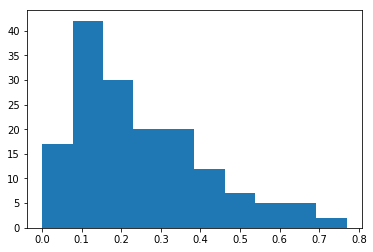

In [150]:
plt.hist(df['mean_hue'])

(array([14.,  5., 11., 20., 36., 32., 25.,  8.,  4.,  5.]),
 array([0.        , 0.08325717, 0.16651434, 0.24977151, 0.33302868,
        0.41628585, 0.49954302, 0.58280019, 0.66605736, 0.74931453,
        0.8325717 ]),
 <a list of 10 Patch objects>)

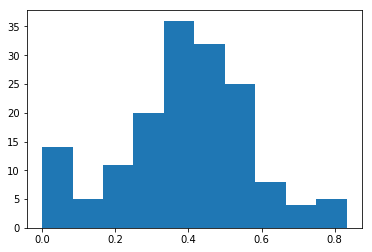

In [151]:
plt.hist(df['mean_saturation'])

(array([ 2.,  7., 21., 22., 35., 35., 21., 12.,  3.,  2.]),
 array([0.21721218, 0.27665557, 0.33609896, 0.39554236, 0.45498575,
        0.51442914, 0.57387253, 0.63331592, 0.69275931, 0.75220271,
        0.8116461 ]),
 <a list of 10 Patch objects>)

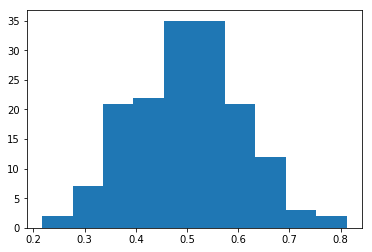

In [152]:
plt.hist(df['mean_value'])

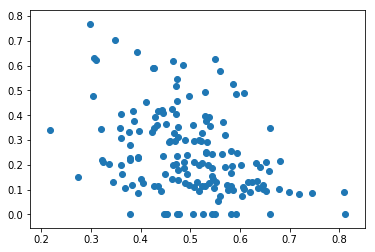

In [153]:
plt.scatter(df['mean_value'], df['mean_hue'])

In [154]:
RESULT_DIR = os.path.join(DATA_DIR, 'results-{artist}'.format(artist=artist_name))
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)

In [155]:
thumbs = os.listdir(THUMB_DIR)

In [190]:
GLOBAL_WIDTH = 5000
bg_color = (192, 192, 192)
figure1 = Image.new('RGB', (GLOBAL_WIDTH, GLOBAL_WIDTH), bg_color)
x_coords = (GLOBAL_WIDTH * df['mean_value']).apply(int)
y_coords = (GLOBAL_WIDTH * df['mean_hue']).apply(int)
for i in range(len(thumbs)):
    thumb_img = Image.open(os.path.join(THUMB_DIR, thumbs[i]))
    figure1.paste(thumb_img, (x_coords[i], y_coords[i]))

In [191]:
figure1.save(os.path.join(RESULT_DIR, 'brightness_vs_hue.jpg'))

In [192]:
bg_color = (192, 192, 192)
figure2 = Image.new('RGB', (GLOBAL_WIDTH, GLOBAL_WIDTH), bg_color)
x_coords = (GLOBAL_WIDTH * df['mean_saturation']).apply(int)
y_coords = (GLOBAL_WIDTH * df['mean_hue']).apply(int)
for i in range(len(thumbs)):
    thumb_img = Image.open(os.path.join(THUMB_DIR, thumbs[i]))
    figure2.paste(thumb_img, (x_coords[i], y_coords[i]))

In [193]:
figure2.save(os.path.join(RESULT_DIR, 'saturation_vs_hue.jpg'))

Calculating advanced image features

In [160]:
def calc_adv_stats(filename):
    image = io.imread(os.path.join(IMAGE_DIR, filename))
    gray_img = rgb2gray(image)
    entr_img = entropy(gray_img, disk(10))
    
    arr = np.array(image, dtype = int)

    deltaX2 = np.square(np.roll(arr, -1, axis = 0) - np.roll(arr, 1, axis = 0))

    deltaY2 = np.square(np.roll(arr, -1, axis = 1) - np.roll(arr, 1, axis = 1))

    dualEnergy = np.sum(deltaX2, axis = 2) + np.sum(deltaY2, axis = 2)
    
    mean_entr = np.mean(entr_img)
    mean_ener = np.mean(dualEnergy)
    return [mean_entr, mean_ener]

In [128]:
df2 = pd.DataFrame(columns = ['mean_entr', 'mean_ener'])
for file in os.listdir(IMAGE_DIR):
    if file.endswith('.jpg'):
        data = calc_adv_stats(file)
        dicti = {'mean_entr': data[0], 'mean_ener': data[1]}
        df2 = df2.append(dicti, ignore_index=True)

In [175]:
normalized_entr = ((df2['mean_entr'] - df2['mean_entr'].min())/(df2['mean_entr'].max()-df2['mean_entr'].min()))
normalized_ener = ((df2['mean_ener'] - df2['mean_ener'].min())/(df2['mean_ener'].max()-df2['mean_ener'].min()))

In [194]:
bg_color = (192, 192, 192)
figure3 = Image.new('RGB', (GLOBAL_WIDTH, GLOBAL_WIDTH), bg_color)
x_coords = (GLOBAL_WIDTH * normalized_entr).apply(int)
y_coords = (GLOBAL_WIDTH * normalized_ener).apply(int)
for i in range(len(thumbs)):
    thumb_img = Image.open(os.path.join(THUMB_DIR, thumbs[i]))
    figure3.paste(thumb_img, (x_coords[i], y_coords[i]))

In [195]:
figure3.save(os.path.join(RESULT_DIR, "mean_entr vs mean_ener.jpg"))

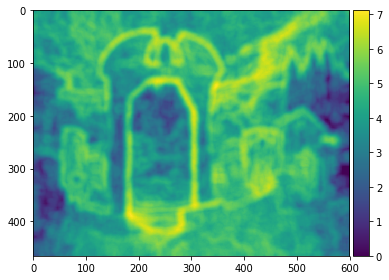

In [201]:
image = io.imread(os.path.join(IMAGE_DIR, 'untitled-195.jpg'))
gray_img = rgb2gray(image)
entr_img = entropy(gray_img, disk(10))
io.imshow(entr_img)